# Sonar (chirp) Data Classification of Underwater Mines and Rocks

## Goal 
Train neural networks on sonar data. Prediction will distinguish two classes: rock and mine (i.e., metal surface). Use various neural network designs and a grid searches on each design to find an optimal model.

## Data

The file "sonar.mines" contains 111 patterns (samples) obtained by bouncing sonar signals off a metal cylinder at various angles and under various conditions. The file "sonar.rocks" contains 97 chirp patterns (samples) reflected from rock surfaces under similar conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock surface.

Each pattern is recorded as values in 60 frequency bins ranging 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time. The integration aperture for higher frequencies occur later in time, since these frequencies are transmitted later during the chirp.

The labels associated are: R = rock and M = mine (metal cylinder). The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly.

Reference:
http://archive.ics.uci.edu/ml/datasets/connectionist+bench+(sonar,+mines+vs.+rocks)

## Imports

In [1]:
import json # for saving the histories of each run
import os.path # directory readout
import shutil # file operations
import time # timing durations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# seeting seeds for random numbers in Keras and TF backend. Setting the seed makes each run reproducible
from numpy.random import seed
seed=seed(1337)
from tensorflow import set_random_seed
set_random_seed(1337)

## Donload data

In [3]:
import os

if os.path.isfile('./sonar.all-data') == False:
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data

--2019-08-31 13:06:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87776 (86K) [application/x-httpd-php]
Saving to: 'sonar.all-data'

     0K .......... .......... .......... .......... .......... 58%  292K 0s
    50K .......... .......... .......... .....                100% 10.6M=0.2s

2019-08-31 13:06:32 (491 KB/s) - 'sonar.all-data' saved [87776/87776]



## Preprocessing in CSV

Rename file to csv.

In [4]:
if os.path.isfile('./sonar.csv') == False:
    os.rename('sonar.all-data','sonar.csv')

Check the data. Note the label at the end of each line. The head contains the rock samples, the tail contains the mines/metal samples. The data is already normalized to a range 0 - 1 and will not require additional normalization.

In [5]:
import tailer # this replicates the linux command !head and !tail for other systems

tailer.head(open('sonar.csv'))

['0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R',
 '0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R',
 '0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974

In [6]:
tailer.tail(open('sonar.csv'))

['0.0238,0.0318,0.0422,0.0399,0.0788,0.0766,0.0881,0.1143,0.1594,0.2048,0.2652,0.3100,0.2381,0.1918,0.1430,0.1735,0.1781,0.2852,0.5036,0.6166,0.7616,0.8125,0.7793,0.8788,0.8813,0.9470,1.0000,0.9739,0.8446,0.6151,0.4302,0.3165,0.2869,0.2017,0.1206,0.0271,0.0580,0.1262,0.1072,0.1082,0.0360,0.1197,0.2061,0.2054,0.1878,0.2047,0.1716,0.1069,0.0477,0.0170,0.0186,0.0096,0.0071,0.0084,0.0038,0.0026,0.0028,0.0013,0.0035,0.0060,M',
 '0.0116,0.0744,0.0367,0.0225,0.0076,0.0545,0.1110,0.1069,0.1708,0.2271,0.3171,0.2882,0.2657,0.2307,0.1889,0.1791,0.2298,0.3715,0.6223,0.7260,0.7934,0.8045,0.8067,0.9173,0.9327,0.9562,1.0000,0.9818,0.8684,0.6381,0.3997,0.3242,0.2835,0.2413,0.2321,0.1260,0.0693,0.0701,0.1439,0.1475,0.0438,0.0469,0.1476,0.1742,0.1555,0.1651,0.1181,0.0720,0.0321,0.0056,0.0202,0.0141,0.0103,0.0100,0.0034,0.0026,0.0037,0.0044,0.0057,0.0035,M',
 '0.0131,0.0387,0.0329,0.0078,0.0721,0.1341,0.1626,0.1902,0.2610,0.3193,0.3468,0.3738,0.3055,0.1926,0.1385,0.2122,0.2758,0.4576,0.6487,0.7154,0.8010

## Load the data into a pandas dataframe and split into Features and Labels

The first 60 fields are frequency measurements from the sonar, the last field is the Label

In [7]:
# load dataset into pandas
df = pd.read_csv("sonar.csv", header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [8]:
# split dataframe into frequency bin features X (columns 0 to 59)
X = df.iloc[:,0:60]
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094


In [9]:
# data frame with labels y (column 60)
y = df.iloc[:,-1]
y.head(5)

0    R
1    R
2    R
3    R
4    R
Name: 60, dtype: object

## How many values are rock and mine?

In [10]:
y.value_counts()

M    111
R     97
Name: 60, dtype: int64

## Visualize the data

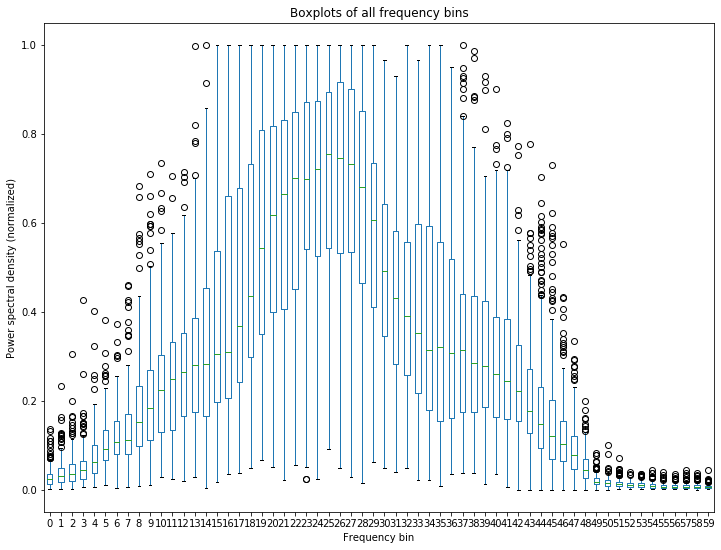

In [11]:
X.plot.box(figsize=(12,9), xticks=[])
plt.title('Boxplots of all frequency bins')
plt.xlabel('Frequency bin')
plt.ylabel('Power spectral density (normalized)')
plt.xticks(np.arange(1, 61, 1))
plt.show()

The data is evenly distributed.

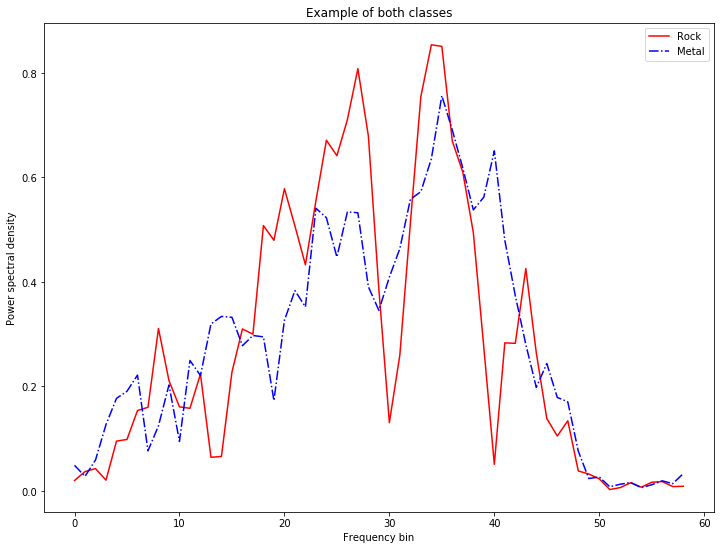

In [12]:
# size
plt.figure(figsize=(12,9))

# select data
plt.plot(X[y == 'R'].values[0][:-1], label='Rock', color='red')
plt.plot(X[y == 'M'].values[0][:-1], label='Metal', color='blue', linestyle='-.')

# additional labeling
plt.legend()
plt.title('Example of both classes')
plt.xlabel('Frequency bin')
plt.ylabel('Power spectral density')

plt.show()

## Label encoding to integers R=1 and M=0

In [13]:
# encode class values as integers R=1 and M=0
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
print("To integers: ",encoded_y)

# convert integers to dummy variables (one-hot-encoded)
onehot_y = np_utils.to_categorical(encoded_y)
print("One-hot: ",onehot_y[0:10])

To integers:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
One-hot:  [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## Splitting in train and test

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, onehot_y, test_size=0.2, shuffle=True, random_state=seed)

print("X train: ",X_train.shape)
print("y train: ",y_train.shape)

print("X test: ",X_test.shape)
print("y test: ",y_test.shape)

X train:  (166, 60)
y train:  (166, 2)
X test:  (42, 60)
y test:  (42, 2)


## Four Deep Learning models of different complexity

The grid search parameter range remains the same across all three model designs! Of course, we could stick to one design and also start a grid search on the dimensions of the hidden layers.

In [15]:
input_dim = 60 # 60 frequency bins
output_dim = 2 # two classes, rock and mine
epochs = 250

# grid search parameters
activation_functions_layer_1 = ['sigmoid','tanh','relu']
optimizers = ['rmsprop','adagrad','adadelta','adam','SGD']
batch_sizes = [4,8,16,32]

num_hyperparams = len(optimizers)*len(activation_functions_layer_1)*len(batch_sizes)

## Model 1: no hidden layers

In [16]:
# for descriptive output
counter = 1

# initialize score df
score_df1 = pd.DataFrame(columns=['optimizers','activation_functions_layer_1','batch_size','train_loss', 'train_accuracy', 'test_loss','test_accuracy', 'save_path'])

# remove folder of run histories from (possible) previous run
if os.path.isdir('Sonar_classification_NN_GridSearch_model1'):
    shutil.rmtree('Sonar_classification_NN_GridSearch_model1')
    os.mkdir('Sonar_classification_NN_GridSearch_model1')
    print("directory emptied")
else:
    os.mkdir('Sonar_classification_NN_GridSearch_model1')
    print("directory created")

# measure time of grid search
start = time.time()

# optimize over hyper parameter grid (grid search)
for activation_function_layer_1 in activation_functions_layer_1:
    for optimizer in optimizers:
        for batch_size in batch_sizes:
            print('Model {} of {}. {}, {}, batch_size={}'.format(counter, num_hyperparams, optimizer, activation_function_layer_1, batch_size))
            counter = counter+1
            
            # model design
            model = Sequential()
            model.add(Dense(input_dim, activation = activation_function_layer_1, input_dim=input_dim))
            model.add(Dense(output_dim, activation='softmax'))

            model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

            history_model = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0, # leaving this on would get very crowded in grid search
                        validation_data=(X_test, y_test))
            
            # save history to a json file for plotting
            save_path = "Sonar_classification_NN_GridSearch_model1\sonar_model_1.%s.%s.%s.json" % (optimizer, activation_function_layer_1, batch_size)
            history_dict1 = history_model.history
            json.dump(history_dict1, open(save_path, 'w'))
            
            train_score = model.evaluate(X_train, y_train, verbose=0)
            test_score = model.evaluate(X_test, y_test, verbose=0)
            
            # data frame with scores of each run
            score_df1 = score_df1.append({'activation_functions_layer_1' : activation_function_layer_1, 'optimizers': optimizer, 'batch_size' : batch_size, 'train_loss' : train_score[0], 'train_accuracy' : train_score[1], 'test_loss' : test_score[0], 'test_accuracy' : test_score[1], 'save_path' : save_path}, ignore_index=True)

# measure time of grid search
end = time.time()
difference = int(round(end - start))
print('Elapsed time: {} seconds'.format(difference))

W0831 13:06:33.926035 11308 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 13:06:33.929027 11308 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:519: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 13:06:33.932019 11308 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4140: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 13:06:33.974905 11308 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimize

directory created
Model 1 of 60. rmsprop, sigmoid, batch_size=4


W0831 13:06:34.099572 11308 deprecation.py:323] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0831 13:06:34.210275 11308 deprecation_wrapper.py:119] From C:\Users\ChristianV700\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:988: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Model 2 of 60. rmsprop, sigmoid, batch_size=8
Model 3 of 60. rmsprop, sigmoid, batch_size=16
Model 4 of 60. rmsprop, sigmoid, batch_size=32
Model 5 of 60. adagrad, sigmoid, batch_size=4
Model 6 of 60. adagrad, sigmoid, batch_size=8
Model 7 of 60. adagrad, sigmoid, batch_size=16
Model 8 of 60. adagrad, sigmoid, batch_size=32
Model 9 of 60. adadelta, sigmoid, batch_size=4
Model 10 of 60. adadelta, sigmoid, batch_size=8
Model 11 of 60. adadelta, sigmoid, batch_size=16
Model 12 of 60. adadelta, sigmoid, batch_size=32
Model 13 of 60. adam, sigmoid, batch_size=4
Model 14 of 60. adam, sigmoid, batch_size=8
Model 15 of 60. adam, sigmoid, batch_size=16
Model 16 of 60. adam, sigmoid, batch_size=32
Model 17 of 60. SGD, sigmoid, batch_size=4
Model 18 of 60. SGD, sigmoid, batch_size=8
Model 19 of 60. SGD, sigmoid, batch_size=16
Model 20 of 60. SGD, sigmoid, batch_size=32
Model 21 of 60. rmsprop, tanh, batch_size=4
Model 22 of 60. rmsprop, tanh, batch_size=8
Model 23 of 60. rmsprop, tanh, batch_size

In [17]:
# rank the grid search by test accuracy
score_df1 = score_df1.sort_values(by=['test_accuracy'], ascending=False)
pd.options.display.max_colwidth = 100
score_df1.reset_index(inplace=True)
score_df1.index = np.arange(1,len(score_df1)+1)
score_df1.head(5)

,index,optimizers,activation_functions_layer_1,batch_size,train_loss,train_accuracy,test_loss,test_accuracy,save_path
1,36,SGD,tanh,4,0.238671,0.909639,0.546156,0.809524,Sonar_classification_NN_GridSearch_model1\sonar_model_1.SGD.tanh.4.json
2,56,SGD,relu,4,0.136203,0.969880,0.485624,0.809524,Sonar_classification_NN_GridSearch_model1\sonar_model_1.SGD.relu.4.json
3,54,adam,relu,16,0.048090,0.993976,0.483538,0.809524,Sonar_classification_NN_GridSearch_model1\sonar_model_1.adam.relu.16.json
4,47,adagrad,relu,32,0.251058,0.921687,0.499554,0.809524,Sonar_classification_NN_GridSearch_model1\sonar_model_1.adagrad.relu.32.json
5,49,adadelta,relu,8,0.041707,1.000000,0.646331,0.809524,Sonar_classification_NN_GridSearch_model1\sonar_model_1.adadelta.relu.8.json


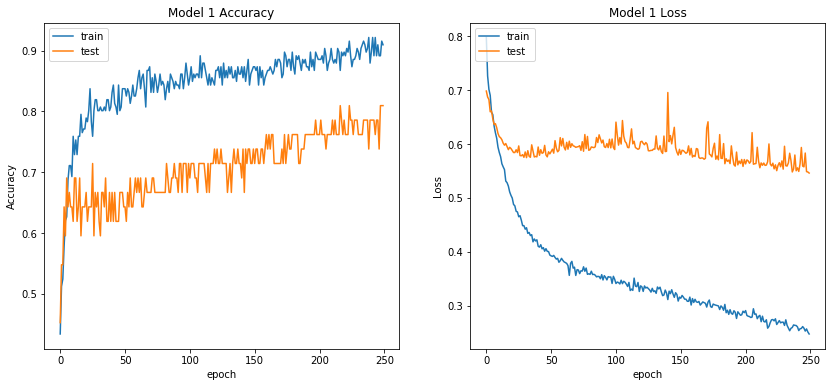

In [18]:
# load the best run and display, now it is not a Keras history type anymore
history_dict1 = json.load(open("Sonar_classification_NN_GridSearch_model1\sonar_model_1.SGD.tanh.4.json", 'r'))

# plot accuracy
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
plt.plot(history_dict1['acc'])
plt.plot(history_dict1['val_acc'])
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# plot loss
plt.subplot(122)
plt.plot(history_dict1['loss'])
plt.plot(history_dict1['val_loss'])
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 2: one hidden layer

In [19]:
# for descriptive output
counter = 1

# initialize score df
score_df2 = pd.DataFrame(columns=['optimizers','activation_functions_layer_1','batch_size','train_loss', 'train_accuracy', 'test_loss','test_accuracy', 'save_path'])

# remove folder of run histories from (possible) previous run
if os.path.isdir('Sonar_classification_NN_GridSearch_model2'):
    shutil.rmtree('Sonar_classification_NN_GridSearch_model2')
    os.mkdir('Sonar_classification_NN_GridSearch_model2')
    print("directory emptied")
else:
    os.mkdir('Sonar_classification_NN_GridSearch_model2')
    print("directory created")

# measure time of grid search
start = time.time()

# optimize over hyper parameter grid (grid search)
for activation_function_layer_1 in activation_functions_layer_1:
    for optimizer in optimizers:
        for batch_size in batch_sizes:
            print('Model {} of {}. {}, {}, batch_size={}'.format(counter, num_hyperparams, optimizer, activation_function_layer_1, batch_size))
            counter = counter+1
            
            # model design
            model = Sequential()
            model.add(Dense(input_dim, activation = activation_function_layer_1, input_dim=input_dim))
            model.add(Dense(3, activation='sigmoid'))
            model.add(Dense(output_dim, activation='softmax'))

            model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

            history_model = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(X_test, y_test))
            
            # save history to a json file for plotting
            save_path = "Sonar_classification_NN_GridSearch_model2\sonar_model_2.%s.%s.%s.json" % (optimizer, activation_function_layer_1, batch_size)
            history_dict2 = history_model.history
            json.dump(history_dict2, open(save_path, 'w'))
            
            train_score = model.evaluate(X_train, y_train, verbose=0)
            test_score = model.evaluate(X_test, y_test, verbose=0)
            
            # data frame with scores of each run
            score_df2 = score_df2.append({'activation_functions_layer_1' : activation_function_layer_1, 'optimizers': optimizer, 'batch_size' : batch_size, 'train_loss' : train_score[0], 'train_accuracy' : train_score[1], 'test_loss' : test_score[0], 'test_accuracy' : test_score[1], 'save_path' : save_path}, ignore_index=True)

# measure time of grid search
end = time.time()
difference = int(round(end - start))
print('Elapsed time: {} seconds'.format(difference))

directory created
Model 1 of 60. rmsprop, sigmoid, batch_size=4
Model 2 of 60. rmsprop, sigmoid, batch_size=8
Model 3 of 60. rmsprop, sigmoid, batch_size=16
Model 4 of 60. rmsprop, sigmoid, batch_size=32
Model 5 of 60. adagrad, sigmoid, batch_size=4
Model 6 of 60. adagrad, sigmoid, batch_size=8
Model 7 of 60. adagrad, sigmoid, batch_size=16
Model 8 of 60. adagrad, sigmoid, batch_size=32
Model 9 of 60. adadelta, sigmoid, batch_size=4
Model 10 of 60. adadelta, sigmoid, batch_size=8
Model 11 of 60. adadelta, sigmoid, batch_size=16
Model 12 of 60. adadelta, sigmoid, batch_size=32
Model 13 of 60. adam, sigmoid, batch_size=4
Model 14 of 60. adam, sigmoid, batch_size=8
Model 15 of 60. adam, sigmoid, batch_size=16
Model 16 of 60. adam, sigmoid, batch_size=32
Model 17 of 60. SGD, sigmoid, batch_size=4
Model 18 of 60. SGD, sigmoid, batch_size=8
Model 19 of 60. SGD, sigmoid, batch_size=16
Model 20 of 60. SGD, sigmoid, batch_size=32
Model 21 of 60. rmsprop, tanh, batch_size=4
Model 22 of 60. rmspr

In [20]:
# rank the grid search by test accuracy
score_df2 = score_df2.sort_values(by=['test_accuracy'], ascending=False)
pd.options.display.max_colwidth = 100
score_df2.reset_index(inplace=True)
score_df2.index = np.arange(1,len(score_df2)+1)
score_df2.head(5)

,index,optimizers,activation_functions_layer_1,batch_size,train_loss,train_accuracy,test_loss,test_accuracy,save_path
1,49,adadelta,relu,8,0.056561,0.993976,0.430995,0.857143,Sonar_classification_NN_GridSearch_model2\sonar_model_2.adadelta.relu.8.json
2,50,adadelta,relu,16,0.093133,0.993976,0.504374,0.833333,Sonar_classification_NN_GridSearch_model2\sonar_model_2.adadelta.relu.16.json
3,33,adam,tanh,8,0.199265,0.945783,0.659468,0.833333,Sonar_classification_NN_GridSearch_model2\sonar_model_2.adam.tanh.8.json
4,32,adam,tanh,4,0.187121,0.945783,0.617271,0.809524,Sonar_classification_NN_GridSearch_model2\sonar_model_2.adam.tanh.4.json
5,20,rmsprop,tanh,4,0.129197,0.969880,0.664565,0.809524,Sonar_classification_NN_GridSearch_model2\sonar_model_2.rmsprop.tanh.4.json


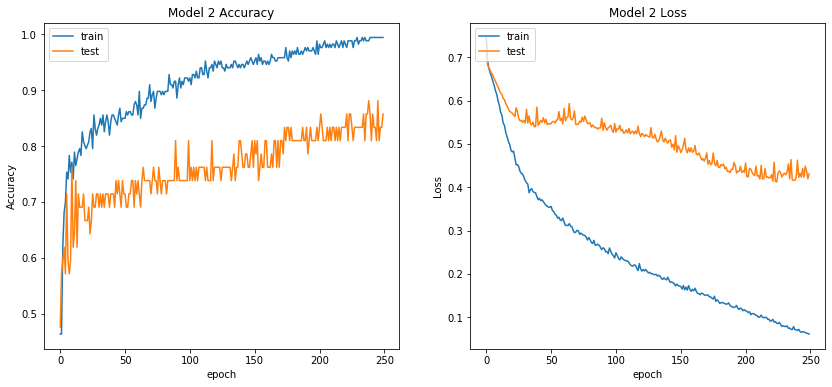

In [21]:
# load the best run and display
history_dict2 = json.load(open("Sonar_classification_NN_GridSearch_model2\sonar_model_2.adadelta.relu.8.json", 'r'))

# plot accuracy
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
plt.plot(history_dict2['acc'])
plt.plot(history_dict2['val_acc'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# plot loss
plt.subplot(122)
plt.plot(history_dict2['loss'])
plt.plot(history_dict2['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 3: three hidden layers

In [22]:
from keras.layers import BatchNormalization

# for descriptive output
counter = 1

# initialize score df
score_df3 = pd.DataFrame(columns=['optimizers','activation_functions_layer_1','batch_size','train_loss', 'train_accuracy', 'test_loss','test_accuracy', 'save_path'])

# remove folder of run histories from (possible) previous run
if os.path.isdir('Sonar_classification_NN_GridSearch_model3'):
    shutil.rmtree('Sonar_classification_NN_GridSearch_model3')
    os.mkdir('Sonar_classification_NN_GridSearch_model3')
    print("directory emptied")
else:
    os.mkdir('Sonar_classification_NN_GridSearch_model3')
    print("directory created")
    
# measure time of grid search
start = time.time()

# optimize over hyper parameter grid (grid search)
for activation_function_layer_1 in activation_functions_layer_1:
    for optimizer in optimizers:
        for batch_size in batch_sizes:
            print('Model {} of {}. {}, {}, batch_size={}'.format(counter, num_hyperparams, optimizer, activation_function_layer_1, batch_size))
            counter = counter+1
            
            # model design
            model = Sequential()
            model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(12, activation='relu'))
            model.add(Dense(6, activation='relu'))
            model.add(Dense(3, activation='relu'))
            model.add(Dense(2, activation='softmax'))

            model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

            history_model = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(X_test, y_test))
            
            # save history to a json file for plotting
            save_path = "Sonar_classification_NN_GridSearch_model3\sonar_model_3.%s.%s.%s.json" % (optimizer, activation_function_layer_1, batch_size)
            history_dict3 = history_model.history
            json.dump(history_dict3, open(save_path, 'w'))
            
            train_score = model.evaluate(X_train, y_train, verbose=0)
            test_score = model.evaluate(X_test, y_test, verbose=0)
            
            # data frame with scores of each run
            score_df3 = score_df3.append({'activation_functions_layer_1' : activation_function_layer_1, 'optimizers': optimizer, 'batch_size' : batch_size, 'train_loss' : train_score[0], 'train_accuracy' : train_score[1], 'test_loss' : test_score[0], 'test_accuracy' : test_score[1], 'save_path' : save_path}, ignore_index=True)

# measure time of grid search
end = time.time()
difference = int(round(end - start))
print('Elapsed time: {} seconds'.format(difference))

directory created
Model 1 of 60. rmsprop, sigmoid, batch_size=4
Model 2 of 60. rmsprop, sigmoid, batch_size=8
Model 3 of 60. rmsprop, sigmoid, batch_size=16
Model 4 of 60. rmsprop, sigmoid, batch_size=32
Model 5 of 60. adagrad, sigmoid, batch_size=4
Model 6 of 60. adagrad, sigmoid, batch_size=8
Model 7 of 60. adagrad, sigmoid, batch_size=16
Model 8 of 60. adagrad, sigmoid, batch_size=32
Model 9 of 60. adadelta, sigmoid, batch_size=4
Model 10 of 60. adadelta, sigmoid, batch_size=8
Model 11 of 60. adadelta, sigmoid, batch_size=16
Model 12 of 60. adadelta, sigmoid, batch_size=32
Model 13 of 60. adam, sigmoid, batch_size=4
Model 14 of 60. adam, sigmoid, batch_size=8
Model 15 of 60. adam, sigmoid, batch_size=16
Model 16 of 60. adam, sigmoid, batch_size=32
Model 17 of 60. SGD, sigmoid, batch_size=4
Model 18 of 60. SGD, sigmoid, batch_size=8
Model 19 of 60. SGD, sigmoid, batch_size=16
Model 20 of 60. SGD, sigmoid, batch_size=32
Model 21 of 60. rmsprop, tanh, batch_size=4
Model 22 of 60. rmspr

In [23]:
# rank the grid search by test accuracy
score_df3 = score_df3.sort_values(by=['test_accuracy'], ascending=False)
pd.options.display.max_colwidth = 100
score_df3.reset_index(inplace=True)
score_df3.index = np.arange(1,len(score_df3)+1)
score_df3.head(5)

,index,optimizers,activation_functions_layer_1,batch_size,train_loss,train_accuracy,test_loss,test_accuracy,save_path
1,20,rmsprop,tanh,4,0.000868,1.000000,0.413791,0.904762,Sonar_classification_NN_GridSearch_model3\sonar_model_3.rmsprop.tanh.4.json
2,39,SGD,tanh,32,0.106787,0.987952,0.468828,0.880952,Sonar_classification_NN_GridSearch_model3\sonar_model_3.SGD.tanh.32.json
3,2,rmsprop,sigmoid,16,0.000101,1.000000,0.629418,0.857143,Sonar_classification_NN_GridSearch_model3\sonar_model_3.rmsprop.sigmoid.16.json
4,5,adagrad,sigmoid,8,0.002022,1.000000,0.590021,0.857143,Sonar_classification_NN_GridSearch_model3\sonar_model_3.adagrad.sigmoid.8.json
5,50,adadelta,relu,16,0.000708,1.000000,0.707304,0.857143,Sonar_classification_NN_GridSearch_model3\sonar_model_3.adadelta.relu.16.json


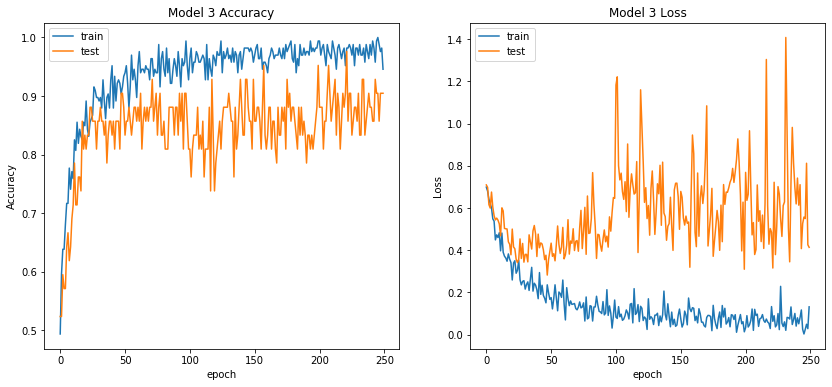

In [24]:
# load the best run and display
history_dict3 = json.load(open("Sonar_classification_NN_GridSearch_model3\sonar_model_3.rmsprop.tanh.4.json", 'r'))

# plot accuracy
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
plt.plot(history_dict3['acc'])
plt.plot(history_dict3['val_acc'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# plot loss
plt.subplot(122)
plt.plot(history_dict3['loss'])
plt.plot(history_dict3['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 4:  four hidden layers

In [25]:
# for descriptive output
counter = 1

# initialize score df
score_df4 = pd.DataFrame(columns=['optimizers','activation_functions_layer_1','batch_size','train_loss', 'train_accuracy', 'test_loss','test_accuracy', 'save_path'])

# remove folder of run histories from (possible) previous run
if os.path.isdir('Sonar_classification_NN_GridSearch_model4'):
    shutil.rmtree('Sonar_classification_NN_GridSearch_model4')
    os.mkdir('Sonar_classification_NN_GridSearch_model4')
    print("directory emptied")
else:
    os.mkdir('Sonar_classification_NN_GridSearch_model4')
    print("directory created")

# measure time of grid search
start = time.time()

# optimize over hyper parameter grid (grid search)
for activation_function_layer_1 in activation_functions_layer_1:
    for optimizer in optimizers:
        for batch_size in batch_sizes:
            print('Model {} of {}. {}, {}, batch_size={}'.format(counter, num_hyperparams, optimizer, activation_function_layer_1, batch_size))
            counter = counter+1
            
            # model design
            model = Sequential()
            model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(24, activation='relu'))
            model.add(Dense(12, activation='relu'))
            model.add(Dense(6, activation='relu'))
            model.add(Dense(3, activation='relu'))
            model.add(Dense(2, activation='softmax'))

            model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

            history_model = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(X_test, y_test))
            
            # save history to a json file for plotting
            save_path = "Sonar_classification_NN_GridSearch_model4\sonar_model_4.%s.%s.%s.json" % (optimizer, activation_function_layer_1, batch_size)
            history_dict4 = history_model.history
            json.dump(history_dict4, open(save_path, 'w'))
            
            train_score = model.evaluate(X_train, y_train, verbose=0)
            test_score = model.evaluate(X_test, y_test, verbose=0)
            
            # data frame with scores of each run
            score_df4 = score_df4.append({'activation_functions_layer_1' : activation_function_layer_1, 'optimizers': optimizer, 'batch_size' : batch_size, 'train_loss' : train_score[0], 'train_accuracy' : train_score[1], 'test_loss' : test_score[0], 'test_accuracy' : test_score[1], 'save_path' : save_path}, ignore_index=True)

# measure time of grid search
end = time.time()
difference = int(round(end - start))
print('Elapsed time: {} seconds'.format(difference))

directory created
Model 1 of 60. rmsprop, sigmoid, batch_size=4
Model 2 of 60. rmsprop, sigmoid, batch_size=8
Model 3 of 60. rmsprop, sigmoid, batch_size=16
Model 4 of 60. rmsprop, sigmoid, batch_size=32
Model 5 of 60. adagrad, sigmoid, batch_size=4
Model 6 of 60. adagrad, sigmoid, batch_size=8
Model 7 of 60. adagrad, sigmoid, batch_size=16
Model 8 of 60. adagrad, sigmoid, batch_size=32
Model 9 of 60. adadelta, sigmoid, batch_size=4
Model 10 of 60. adadelta, sigmoid, batch_size=8
Model 11 of 60. adadelta, sigmoid, batch_size=16
Model 12 of 60. adadelta, sigmoid, batch_size=32
Model 13 of 60. adam, sigmoid, batch_size=4
Model 14 of 60. adam, sigmoid, batch_size=8
Model 15 of 60. adam, sigmoid, batch_size=16
Model 16 of 60. adam, sigmoid, batch_size=32
Model 17 of 60. SGD, sigmoid, batch_size=4
Model 18 of 60. SGD, sigmoid, batch_size=8
Model 19 of 60. SGD, sigmoid, batch_size=16
Model 20 of 60. SGD, sigmoid, batch_size=32
Model 21 of 60. rmsprop, tanh, batch_size=4
Model 22 of 60. rmspr

In [26]:
# rank the grid search by test accuracy
score_df4 = score_df4.sort_values(by=['test_accuracy'], ascending=False)
pd.options.display.max_colwidth = 100
score_df4.reset_index(inplace=True)
score_df4.index = np.arange(1,len(score_df4)+1)
score_df4.head(5)

,index,optimizers,activation_functions_layer_1,batch_size,train_loss,train_accuracy,test_loss,test_accuracy,save_path
1,50,adadelta,relu,16,0.000738,1.0,0.477472,0.928571,Sonar_classification_NN_GridSearch_model4\sonar_model_4.adadelta.relu.16.json
2,22,rmsprop,tanh,16,0.006473,1.0,0.579383,0.928571,Sonar_classification_NN_GridSearch_model4\sonar_model_4.rmsprop.tanh.16.json
3,12,adam,sigmoid,4,0.002931,1.0,0.383726,0.904762,Sonar_classification_NN_GridSearch_model4\sonar_model_4.adam.sigmoid.4.json
4,59,SGD,relu,32,0.018749,1.0,0.389773,0.880952,Sonar_classification_NN_GridSearch_model4\sonar_model_4.SGD.relu.32.json
5,13,adam,sigmoid,8,0.002606,1.0,0.870046,0.880952,Sonar_classification_NN_GridSearch_model4\sonar_model_4.adam.sigmoid.8.json


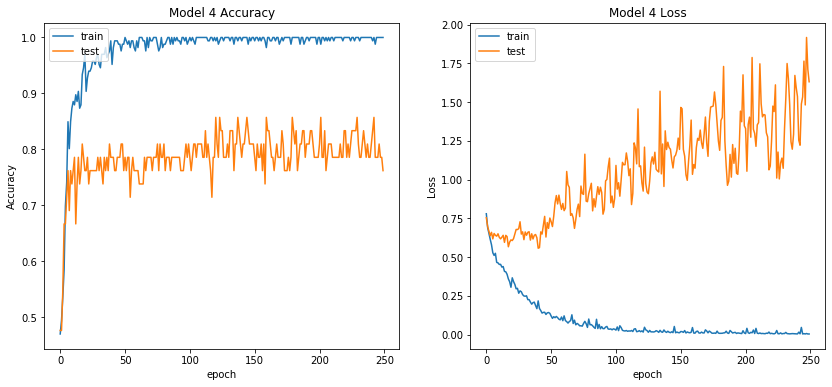

In [27]:
# load the best run and display
history_dict4 = json.load(open("Sonar_classification_NN_GridSearch_model4\sonar_model_4.adadelta.relu.8.json", 'r'))

# plot accuracy
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
plt.plot(history_dict4['acc'])
plt.plot(history_dict4['val_acc'])
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# plot loss
plt.subplot(122)
plt.plot(history_dict4['loss'])
plt.plot(history_dict4['val_loss'])
plt.title('Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
df_comp = pd.concat([score_df1.iloc[[0]], score_df2.iloc[[0]],score_df3.iloc[[0]],score_df4.iloc[[0]]], axis=0)
df_comp.index = np.arange(1,len(df_comp)+1)
df_comp = df_comp.drop(['index'], axis=1)
df_comp

,optimizers,activation_functions_layer_1,batch_size,train_loss,train_accuracy,test_loss,test_accuracy,save_path
1,SGD,tanh,4,0.238671,0.909639,0.546156,0.809524,Sonar_classification_NN_GridSearch_model1\sonar_model_1.SGD.tanh.4.json
2,adadelta,relu,8,0.056561,0.993976,0.430995,0.857143,Sonar_classification_NN_GridSearch_model2\sonar_model_2.adadelta.relu.8.json
3,rmsprop,tanh,4,0.000868,1.000000,0.413791,0.904762,Sonar_classification_NN_GridSearch_model3\sonar_model_3.rmsprop.tanh.4.json
4,adadelta,relu,16,0.000738,1.000000,0.477472,0.928571,Sonar_classification_NN_GridSearch_model4\sonar_model_4.adadelta.relu.16.json


## Conclusion

All four best performing models do a good job at learning the training set. The more complex models three and four with 100% accuracy!

A good fit is the goal of the learning algorithm and exists between an overfit and underfit model.

However, all four best models seem to suffer from **overfitting** shown by the large gap between the two final loss values resulting in an increase in generalization error. The results are not very satisfying and regularization lies outside of the grid search parameters. A less complicated model design would be best for this data set and we should add a few features that **improve generalization**.
